In [59]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
import torch
import numpy as np
import os
import pickle
import gzip
import pandas
from matplotlib import pyplot as plt
from pathlib import Path
from nuplan.planning.training.preprocessing.features.vector_set_map import VectorSetMap
from nuplan.planning.training.preprocessing.features.generic_agents import GenericAgents
from nuplan_extent.planning.training.modeling.models.gameformer_model import GameFormer
from nuplan.planning.simulation.trajectory.trajectory_sampling import TrajectorySampling

torch.set_printoptions(threshold=15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
agents_data = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500/2021.05.12.22.28.35_veh-35_00620_01164/high_magnitude_speed/025dcbd9962b5544/generic_agents.gz"
map_data = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500/2021.05.12.22.28.35_veh-35_00620_01164/high_magnitude_speed/025dcbd9962b5544/vector_set_map.gz"

with gzip.open(agents_data, "rb") as f:
    agents_content = pickle.load(f)
    
with gzip.open(map_data, "rb") as f:
    map_content = pickle.load(f)

plt.figure(figsize=(10,10))
num_vehicle = agents_content['agents']['VEHICLE'][0].shape[1]
for i in range(num_vehicle):
    vehicle = agents_content['agents']['VEHICLE'][0][:, i, :2]
    plt.plot(vehicle[:, 0], vehicle[:, 1], '.-')

for lane in map_content['coords']['LANE'][0]:
    plt.plot(lane[:, 0], lane[:, 1], ',-k')
for lane in map_content['coords']['LEFT_BOUNDARY'][0]:
    plt.plot(lane[:, 0], lane[:, 1], ',-y', alpha=0.1)
for lane in map_content['coords']['RIGHT_BOUNDARY'][0]:
    plt.plot(lane[:, 0], lane[:, 1], ',-y', alpha=0.1)
for cw in map_content['coords']['CROSSWALK'][0]:
    cww = cw[cw[:,0]!=0]
    plt.plot(cww[:, 0], cww[:, 1], 'y,-')
for ss in map_content['coords']['STOP_LINE'][0]:
    sss = ss[ss[:,0]!=0]
    plt.plot(sss[:, 0], sss[:, 1], 'm,-')
plt.axis('equal')

In [ ]:
map_data = VectorSetMap.collate([VectorSetMap.deserialize(map_content)]).to_feature_tensor()
agents_data = GenericAgents.collate([GenericAgents.deserialize(agents_content)]).to_feature_tensor()

In [109]:
# Construct a model
num_target_agents = 11
input_agent_dim = 11
input_lane_dim = 12
input_crosswalk_dim = 2
hidden_feature_dim = 256
num_encoder_layers = 6
num_decoder_layers_lvl0 = 6
num_decoder_modules_lvlk = 6
num_modalities = 6
model = GameFormer([], [], TrajectorySampling(20, 2), TrajectorySampling(16, 8), num_target_agents, input_agent_dim, input_lane_dim, input_crosswalk_dim, hidden_feature_dim)

In [ ]:
processed_map = model.process_map_data_to_tensors({"vector_set_map": map_data})
print(processed_map.keys())

print(processed_map['lane'].shape)
print(processed_map['lane_mask'].shape)
print(processed_map['stopline_crosswalk'].shape)
print(processed_map['stopline_crosswalk_mask'].shape)

In [ ]:
processed_agents = model.process_agent_data_to_tensors({"generic_agents": agents_data})
print(processed_agents.keys())
print(processed_agents['ego'].shape)
print(processed_agents['agents'].shape)
print(processed_agents['agents_mask'].shape)

In [ ]:
plt.figure(figsize=(10,10))
for lane in processed_map['lane'].numpy()[0,0]:
    plt.plot(lane[:, 0], lane[:, 1], 'k')
for stopline in processed_map['stopline_crosswalk'].numpy()[0,0]:
    stopline_draw = stopline[stopline[:, 0] != 0]
    plt.plot(stopline_draw[:, 0], stopline_draw[:, 1], 'y,-')
for ego in processed_agents['ego'].numpy()[0]:
    plt.plot(ego[:, 0], ego[:, 1], '.-b')
for other in processed_agents['agents'].numpy()[0]:
    plt.plot(other[:, 0], other[:, 1], '.-r', alpha=0.3)
plt.grid('on')
plt.axis('equal')

---

# New batch of data

## Statistics

In [51]:
meta_path = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_metadata/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_v2_metadata_node_0.csv"
list_files = pandas.read_csv(meta_path)

In [95]:
print(f"The total number of scenarios is {len(list_files) // 4}")
scenario_types = {}
set_paths = set([Path(i).parent for i in list_files['file_name'].to_list()])
for path in set_paths:
    stype = path.parents[0].stem
    scenario_types[stype] = scenario_types.get(stype, 0) + 1
scenario_pd = pandas.DataFrame.from_dict(scenario_types, orient='index')
scenario_pd = scenario_pd.rename(columns={0: "count"})
print(scenario_pd)

The total number of scenarios is 27943
                                                    count
near_long_vehicle                                    1332
traversing_traffic_light_intersection                1500
on_stopline_stop_sign                                1412
medium_magnitude_speed                               1500
on_intersection                                      1226
stationary_at_traffic_light_without_lead             1500
stationary                                           1500
on_pickup_dropoff                                    1500
near_high_speed_vehicle                              1500
traversing_intersection                              1500
stationary_in_traffic                                1500
near_multiple_vehicles                                495
following_lane_with_slow_lead                         490
unknown                                              1500
near_trafficcone_on_driveable                         360
stationary_at_traffic_light_with_

In [119]:
path = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets/2021.06.03.12.02.06_veh-35_00233_00609/unknown/b36cb91e1495574c/"
agents_past_data = os.path.join(path, "generic_agents.gz")
agents_future_data = os.path.join(path, "agents_trajectory_target.gz")
ego_target_data = os.path.join(path, "trajectory.gz")
map_data = os.path.join(path, "vector_set_map.gz")

In [120]:
with gzip.open(agents_past_data, "rb") as f:
    past = pickle.load(f)
    
with gzip.open(agents_future_data, "rb") as f:
    future = pickle.load(f)
    
with gzip.open(ego_target_data, "rb") as f:
    ego_future = pickle.load(f)

with gzip.open(map_data, "rb") as f:
    maps = pickle.load(f)

In [125]:
for path in set_paths:
    agents_past_data = os.path.join(path, "generic_agents.gz")
    with gzip.open(agents_past_data, "rb") as f:
        past = pickle.load(f)
    if past['agents']['VEHICLE'][0].shape[1] + past['agents']['PEDESTRIAN'][0].shape[1] + past['agents']['BICYCLE'][0].shape[1] < 10:
        break

In [121]:
print("=====past=====")
for key, val in past['agents'].items():
    print(key, val[0].shape)
print("=====future=====")
for key, val in future['agents'].items():
    print(key, val[0].shape)
print("=====ego future=====")
print(ego_future['data'].shape)

=====past=====
VEHICLE (21, 10, 11)
PEDESTRIAN (21, 0, 11)
BICYCLE (21, 0, 11)
=====future=====
VEHICLE (16, 10, 3)
PEDESTRIAN (16, 0, 3)
BICYCLE (16, 0, 3)
=====ego future=====
(16, 3)


(-99.66369132995605, 72.14926414489746, -13.16212248802185, 51.43179965019226)

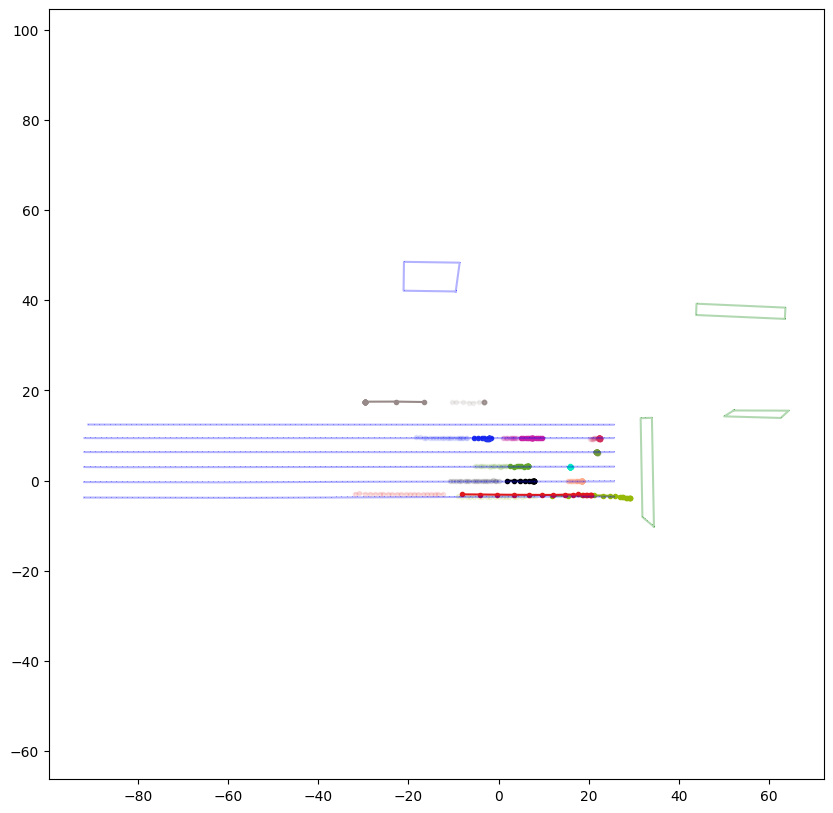

In [122]:
plt.figure(figsize=(10,10))

for agent in ['VEHICLE', 'PEDESTRIAN', 'BICYCLE']:
    num_vehicle = past['agents'][agent][0].shape[1]
    for i in range(num_vehicle):
        color = np.random.rand(3,)
        
        vehicle = past['agents'][agent][0][:, i, :2]
        plt.plot(vehicle[:, 0], vehicle[:, 1], '.-', c=color, alpha=0.1)
        
        vehicle_future = future['agents'][agent][0][:, i, :2]
        plt.plot(vehicle_future[:, 0], vehicle_future[:, 1], '.-', c=color)

# Ego track
plt.plot(past['ego'][0][:, 0], past['ego'][0][:, 1], 'k.-', alpha=0.1)
plt.plot(ego_future['data'][:, 0], ego_future['data'][:, 1], 'k.-')

# Map data
for lane in maps['coords']['LANE'][0]:
    plt.plot(lane[:, 0], lane[:, 1], 'b,-', alpha=0.3)
for lane in maps['coords']['CROSSWALK'][0]:
    lane = lane[lane[:, 0]!=0]
    plt.plot(lane[:, 0], lane[:, 1], 'b,-', alpha=0.3)
for lane in maps['coords']['STOP_LINE'][0]:
    lane = lane[lane[:, 0]!=0]
    plt.plot(lane[:, 0], lane[:, 1], 'g,-', alpha=0.3)
plt.axis('equal')

In [129]:
map_data = VectorSetMap.collate([VectorSetMap.deserialize(maps)]).to_feature_tensor()
agents_data = GenericAgents.collate([GenericAgents.deserialize(past)]).to_feature_tensor()
future_data = GenericAgents.collate([GenericAgents.deserialize(future)]).to_feature_tensor()

In [110]:
processed_map = model.process_map_data_to_tensors({"vector_set_map": map_data})
print(processed_map.keys())

print(processed_map['lane'].shape)
print(processed_map['lane_mask'].shape)
print(processed_map['stopline_crosswalk'].shape)
print(processed_map['stopline_crosswalk_mask'].shape)

dict_keys(['lane', 'lane_mask', 'stopline_crosswalk', 'stopline_crosswalk_mask'])
torch.Size([1, 1, 6, 100, 12])
torch.Size([1, 1, 6, 100])
torch.Size([1, 1, 8, 100, 2])
torch.Size([1, 1, 8, 100])


In [130]:
processed_agents = model.process_agent_data_to_tensors({"generic_agents": agents_data})
print(processed_agents.keys())
print(processed_agents['ego'].shape)
print(processed_agents['agents'].shape)
print(processed_agents['agents_mask'].shape)

dict_keys(['ego', 'agents', 'agents_mask'])
torch.Size([1, 1, 21, 11])
torch.Size([1, 10, 21, 11])
torch.Size([1, 10, 21])


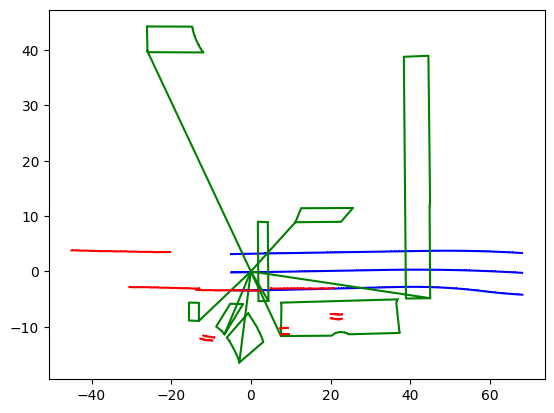

In [114]:
for i in range(6):
    plt.plot(processed_map['lane'][0,0,i,:,0], processed_map['lane'][0,0,i,:,1], ',-b')
for i in range(8):
    plt.plot(processed_map['stopline_crosswalk'][0,0,i,:,0], processed_map['stopline_crosswalk'][0,0,i,:,1], ',-g')
for i in range(10):
    plt.plot(processed_agents['agents'][0,i,:,0], processed_agents['agents'][0,i,:,1], ',-r')